# This notebook performs following operations:
## 1. Data Preparation

	•	Historical Data: Gather historical price data (like the close prices) along with other relevant features such as open, high, low, volume, moving averages, RSI, etc.
	•	Target Variable: Define the target variable. For predicting the direction, you can create a binary variable:
	•	1 if the next period’s price is higher than the current period’s price (indicating an increase).
	•	0 if the next period’s price is lower than the current period’s price (indicating a decrease).

## 2. Feature Engineering

	•	Technical Indicators: Compute technical indicators like Moving Averages (SMA, EMA), Relative Strength Index (RSI), MACD, Bollinger Bands, etc.
	•	Lagged Features: Use lagged values of the price as features, such as the previous day’s close, the day before that, etc.
	•	Windowed Features: Calculate features over a window, such as the rolling mean or standard deviation.

## 3. Making use of ML to determine direction(Up/Down) of prices (in a daywise window)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import ta  # Technical Analysis library
import xgboost as xgb
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
data = pd.read_csv('EURUSD_data')

### Performing feature engineering:

In [4]:
# Feature Engineering
# Calculate Technical Indicators
data['SMA'] = data['Close'].rolling(window=14).mean()
data['EMA'] = data['Close'].ewm(span=14, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['MACD'] = ta.trend.MACD(data['Close']).macd()
data['Bollinger_Upper'] = ta.volatility.BollingerBands(data['Close']).bollinger_hband()
data['Bollinger_Lower'] = ta.volatility.BollingerBands(data['Close']).bollinger_lband()

# Create Lagged Features
for lag in range(1, 4):
    data[f'Lag_{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN values
data.dropna(inplace=True)

# Define the target variable (Binary: 1 for up, 0 for down)
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

### Preprocessing the data:

In [5]:
# Select features and target
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 
                 'Bollinger_Upper', 'Bollinger_Lower', 'Lag_1', 'Lag_2', 'Lag_3']]
target = data['Target']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, shuffle=False)

## Applying following ML models:

### 1. LSTM

In [6]:
# Reshape the input for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=168, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

Epoch 1/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.7597 - val_loss: 0.4396 - val_accuracy: 0.8062
Epoch 2/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.7873 - val_loss: 0.4238 - val_accuracy: 0.8120
Epoch 3/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.7815 - val_loss: 0.4266 - val_accuracy: 0.8120
Epoch 4/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4547 - accuracy: 0.7883 - val_loss: 0.4369 - val_accuracy: 0.8004
Epoch 5/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7820 - val_loss: 0.4273 - val_accuracy: 0.8043
Epoch 6/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4522 - accuracy: 0.7907 - val_loss: 0.4784 - val_accuracy: 0.7713
Epoch 7/168
65/65 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.7723 - val_loss: 0.4243 - val_accuracy: 0.8062
Epoch 8/168
6

In [48]:
# Saving the model

import pickle

# Assume 'model' is your trained LSTM model
model_filename = 'Direction_LSTM.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(lstm_model, file)

print(f"Model saved as {model_filename}")

Model saved as Direction_LSTM.pkl


In [40]:
# Predicting the direction with LSTM
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

17/17 [==============================] - 0s 677us/step


In [41]:
# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Model Accuracy: {accuracy_lstm}")

LSTM Model Accuracy: 0.812015503875969


### 2. XGB Model

In [42]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, learning_rate=0.03)

In [43]:
# Train the XGBoost model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
# Predicting the direction with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

In [45]:
# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb}")

XGBoost Model Accuracy: 0.6375968992248062


## Graphical Analysis:

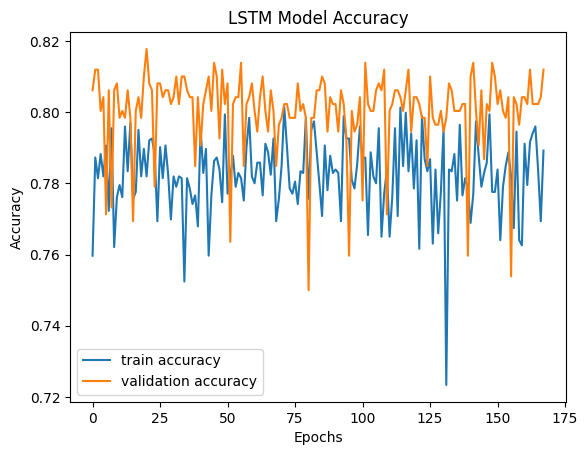

In [46]:
# Plot the accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()